<a href="https://colab.research.google.com/github/halukcansarioz/coklu-nesne-takibi/blob/main/Derin_%C3%96%C4%9Frenme_ve_Yapay_Sinir_A%C4%9Flar%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Kütüphane Kurulumları ---
# Video işleme (ffmpeg) aracını yüklüyoruz.
!apt-get install ffmpeg -y

import os

print(">>> Veri seti hazırlık aşaması başladı...")

# --- Veri İndirme ---
# Makaledeki veri seti çok büyük olduğu için, IBM'in açık kaynaklı veri setinden
# makale konusuna uygun (basketbol) bir örnek video çekiyoruz.
# wget: Dosya indirme komutudur.
!wget -O ham_video.mp4 https://github.com/IBM/MAX-Sports-Video-Classifier/raw/master/samples/basketball.mp4

# --- Veri Ön İşleme (Preprocessing) ---
# İndirilen video var mı kontrol ediyoruz.
if os.path.exists("ham_video.mp4"):
    print("Video başarıyla indirildi. İşleniyor...")

    # ffmpeg kullanarak videonun sadece ilk 10 saniyesini kesiyoruz.
    # Bu işlem, projenin Colab üzerinde hızlı sonuç vermesi (demo) için yapılmıştır.
    # -ss: Başlangıç süresi, -t: Süre uzunluğu
    !ffmpeg -y -i ham_video.mp4 -t 00:00:10 -c:v libx264 -c:a copy spor_videosu.mp4

    if os.path.exists("spor_videosu.mp4"):
        print("\n✅ BAŞARILI: Veri seti analize hazır hale getirildi.")
    else:
        print("❌ HATA: Video kesme işleminde sorun oluştu.")
else:
    print("❌ HATA: Kaynak video indirilemedi.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
>>> Veri seti hazırlık aşaması başladı...
--2025-12-11 15:23:19--  https://github.com/IBM/MAX-Sports-Video-Classifier/raw/master/samples/basketball.mp4
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/MAX-Sports-Video-Classifier/master/samples/basketball.mp4 [following]
--2025-12-11 15:23:22--  https://raw.githubusercontent.com/IBM/MAX-Sports-Video-Classifier/master/samples/basketball.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [ ]:
# --- Gerekli Yapay Zeka Kütüphanesi ---
# Ultralytics, modern nesne takibi (MOT) algoritmalarını içerir.
!pip install ultralytics
from ultralytics import YOLO
import shutil
import os

# --- Model Seçimi ---
# Makaledeki gibi yüksek doğruluk için "YOLOv8 Medium" modelini seçtik.
# Bu model, görüntüdeki nesneleri tespit etmekten (Detection) sorumludur.
model = YOLO('yolov8m.pt')

print("Model belleğe yüklendi, analiz başlıyor...")

# --- Çoklu Nesne Takibi (Multi-Object Tracking) ---
# Burada "Tracking-by-Detection" yöntemini uyguluyoruz.
# source: İşlenecek video dosyamız.
# conf=0.3: Güven skoru %30'un altındaki tespitleri yok say (Hataları azaltmak için).
# tracker="bytetrack.yaml": Makalede de referans verilen 'ByteTrack' algoritmasını kullanıyoruz.
# ByteTrack, düşük skorlu nesneleri de takip ederek oyuncu kayıplarını (occlusion) azaltır.
# classes=[0]: Sadece 'insan' sınıfını takip et (Topu veya potayı değil).
results = model.track(
    source="spor_videosu.mp4",
    conf=0.3,
    iou=0.5,
    save=True,
    tracker="bytetrack.yaml",
    classes=[0],
    project='.',
    name='sonuc',
    exist_ok=True
)

print(">>> Analiz tamamlandı! Oyuncular tespit edildi ve kimlik atamaları (ID) yapıldı.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
WARNING ⚠️ Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8m.pt... HTTP Error 503: Service Unavailable
Model belleğe yüklendi, analiz başlıyor...
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 91ms
Prepared 1 package in 42ms
Installed 1 package in 1ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 0.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


WARNING ⚠️ 
inference results will accumulate in RAM unle

In [ ]:
import os

# YOLO'nun oluşturduğu sonuç videosunun yolu
output_video = "sonuc/spor_videosu.avi"

if os.path.exists(output_video):
    print(f"İşlenmiş video bulundu: {output_video}")

    # --- Format Dönüştürme ve Kaydetme ---
    # Videoyu MP4 formatına çevirip doğrudan Colab'in dosya sistemine kaydediyoruz.
    # Bilgisayarına indirme (files.download) satırını kaldırdık.
    print("Video MP4 formatına dönüştürülüyor, lütfen bekleyin...")
    !ffmpeg -y -i {output_video} -vcodec libx264 final_proje_videosu.mp4

    if os.path.exists("final_proje_videosu.mp4"):
        print("\n✅ İŞLEM TAMAM: Video Colab dosyalarına kaydedildi!")
        print("-" * 50)
        print("Videoyu İzlemek İçin:")
        print("1. Sol menüdeki 'Klasör' (Dosyalar) simgesine tıkla.")
        print("2. Listede 'final_proje_videosu.mp4' dosyasını göreceksin.")
        print("3. İstersen dosyaya çift tıklayarak önizleme yapabilirsin.")
        print("-" * 50)
    else:
        print("❌ HATA: Dönüştürme başarısız oldu.")
else:
    print("❌ HATA: Analiz sonucu bulunamadı. Lütfen önce 2. Adım'ı çalıştırın.")

İşlenmiş video bulundu: sonuc/spor_videosu.avi
Video MP4 formatına dönüştürülüyor, lütfen bekleyin...
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libss

In [ ]:
# --- Gerekli Kütüphaneler ---
!pip install ultralytics opencv-python matplotlib numpy
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from collections import defaultdict
import os

# --- Model ve Ayarlar ---
model = YOLO('yolov8m.pt')
video_path = "spor_videosu.mp4"

print("Gelişmiş analiz başlıyor... Bu işlem sırasında veriler toplanacak.")

# --- Veri Saklama Yapıları ---
# Hangi karede kaç oyuncu var?
active_tracks_per_frame = []
# Her bir ID'nin hangi karelerde görüldüğü (ömrünü hesaplamak için)
track_lifespans = defaultdict(list)
# Örnek kareleri saklamak için (Görselleştirme 1 için)
sample_frames = {}
frame_count = 0
total_frames_approx = 300 # 10 saniye * 30 fps tahmini

# --- Analiz Döngüsü (Stream Mode) ---
# stream=True diyerek sonuçları anlık alıyoruz
results = model.track(source=video_path, conf=0.3, iou=0.5, tracker="bytetrack.yaml", classes=[0], stream=True, verbose=False)

for r in results:
    frame_count += 1

    # Bu karedeki tespit edilen ID'leri al
    if r.boxes.id is not None:
        # ID'leri CPU'ya al ve numpy dizisine çevir
        current_ids = r.boxes.id.cpu().numpy().astype(int)

        # Grafik 1 için veri: Bu karedeki aktif kişi sayısı
        active_tracks_per_frame.append(len(current_ids))

        # Grafik 2 için veri: Her ID'nin görüldüğü kareyi kaydet
        for obj_id in current_ids:
            track_lifespans[obj_id].append(frame_count)
    else:
        active_tracks_per_frame.append(0)

    # Görselleştirme 1 için: Belirli aralıklarla kare örnekleri al
    # (Örneğin başı, ortası ve sonuna yakın kareler)
    if frame_count in [30, 150, 250]:
        # İşlenmiş kareyi (üzerinde kutular olan) al
        annotated_frame = r.plot()
        # Renk formatını BGR'den RGB'ye çevir (Matplotlib için)
        annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        sample_frames[frame_count] = annotated_frame_rgb

    if frame_count % 50 == 0:
        print(f"İşlenen Kare Sayısı: {frame_count}...")

print(f"\nAnaliz Tamamlandı! Toplam {frame_count} kare işlendi.")
print("Şimdi aşağıdaki görselleştirme kodlarını çalıştırabilirsin.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Gelişmiş analiz başlıyor... Bu işlem sırasında veriler toplanacak.
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 104ms
Prepared 1 package in 25ms
Installed 1 package in 4ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 0.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect



FileNotFoundError: spor_videosu.mp4 does not exist

Görsel kaydedildi: Rapor_Gorseli_1_OrnekKareler.png


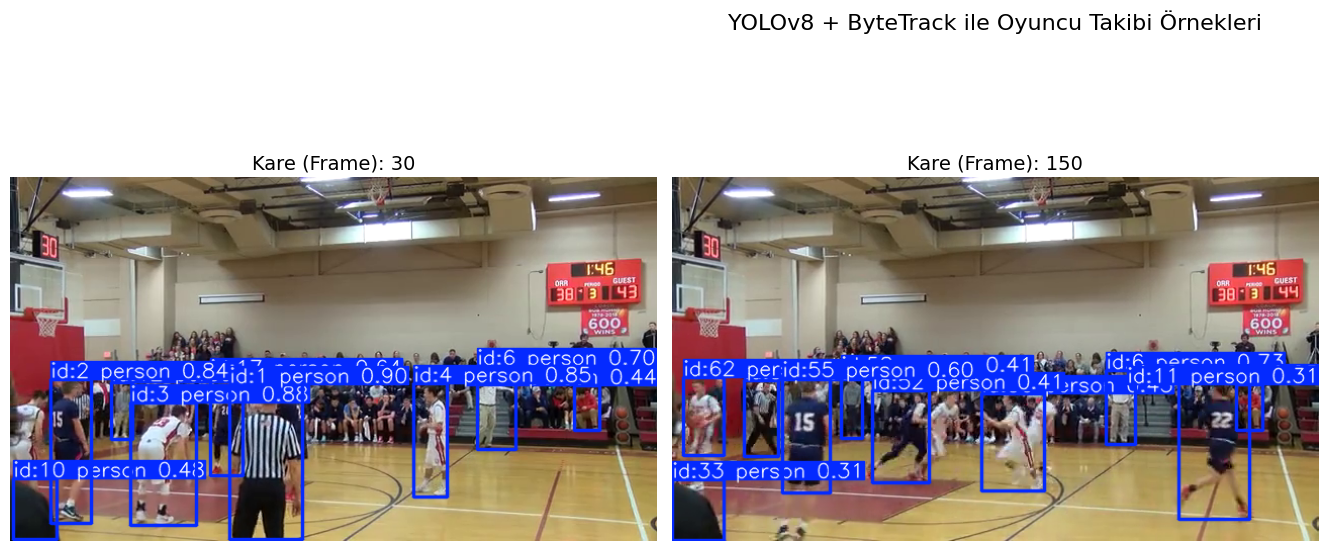

In [ ]:
# --- Görselleştirme 1: Örnek Takip Kareleri ---
plt.figure(figsize=(20, 6)) # Geniş bir figür aç

# Kaydettiğimiz örnek kareleri yan yana çizelim
for i, (frame_idx, frame_img) in enumerate(sample_frames.items()):
    plt.subplot(1, 3, i+1) # 1 satır, 3 sütunluk düzen
    plt.imshow(frame_img)
    plt.title(f"Kare (Frame): {frame_idx}", fontsize=14)
    plt.axis('off') # Eksenleri kapat

plt.suptitle("YOLOv8 + ByteTrack ile Oyuncu Takibi Örnekleri", fontsize=16, y=1.05)
plt.tight_layout()

# Görseli kaydet (Rapor için indirilebilir)
plt.savefig("Rapor_Gorseli_1_OrnekKareler.png", bbox_inches='tight', dpi=150)
print("Görsel kaydedildi: Rapor_Gorseli_1_OrnekKareler.png")
plt.show()

Görsel kaydedildi: Rapor_Gorseli_2_AktifOyuncuGrafigi.png


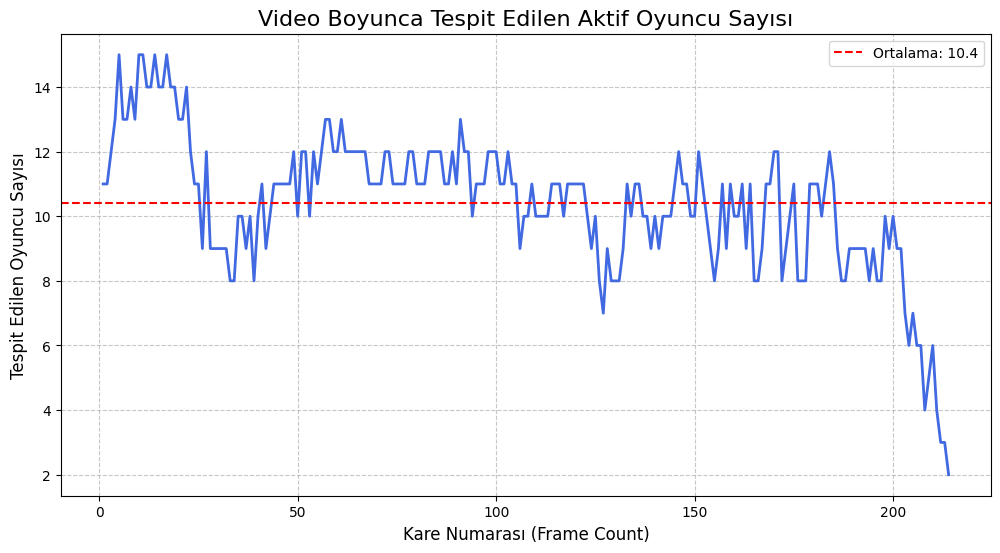

In [ ]:
# --- Görselleştirme 2: Zamana Bağlı Aktif Oyuncu Grafiği ---
plt.figure(figsize=(12, 6))

# X ekseni: Kare numaraları, Y ekseni: O karedeki kişi sayısı
plt.plot(range(1, len(active_tracks_per_frame) + 1), active_tracks_per_frame, color='royalblue', linewidth=2)

plt.title("Video Boyunca Tespit Edilen Aktif Oyuncu Sayısı", fontsize=16)
plt.xlabel("Kare Numarası (Frame Count)", fontsize=12)
plt.ylabel("Tespit Edilen Oyuncu Sayısı", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Ortalama oyuncu sayısını gösteren bir çizgi ekleyelim
avg_players = np.mean(active_tracks_per_frame)
plt.axhline(y=avg_players, color='red', linestyle='--', label=f'Ortalama: {avg_players:.1f}')
plt.legend()

# Görseli kaydet
plt.savefig("Rapor_Gorseli_2_AktifOyuncuGrafigi.png", bbox_inches='tight', dpi=150)
print("Görsel kaydedildi: Rapor_Gorseli_2_AktifOyuncuGrafigi.png")
plt.show()

Görsel kaydedildi: Rapor_Gorseli_3_ID_Omur_Histogrami.png


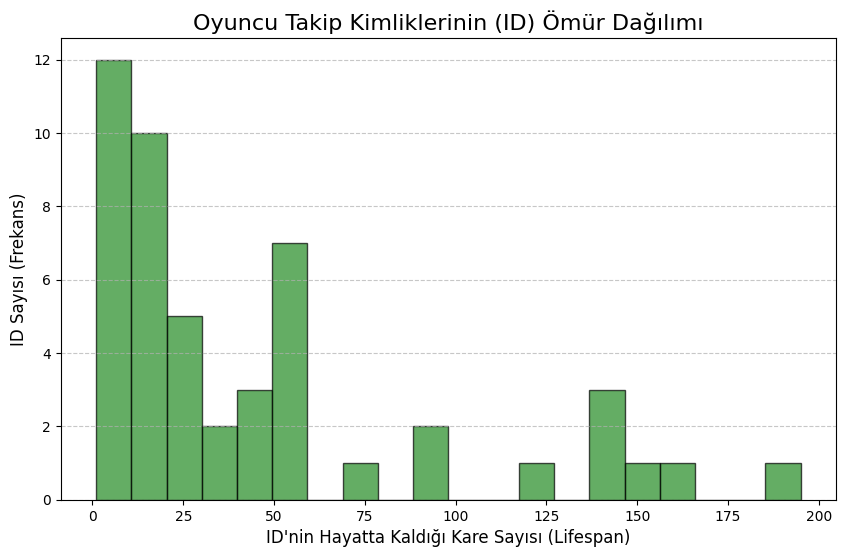

In [ ]:
# --- Görselleştirme 3: Takip Ömrü (Lifespan) Histogramı ---

# Her bir ID'nin kaç kare boyunca hayatta kaldığını hesapla
lifespans = [len(frames) for frames in track_lifespans.values()]

plt.figure(figsize=(10, 6))
# Histogram çizimi
plt.hist(lifespans, bins=20, color='forestgreen', edgecolor='black', alpha=0.7)

plt.title("Oyuncu Takip Kimliklerinin (ID) Ömür Dağılımı", fontsize=16)
plt.xlabel("ID'nin Hayatta Kaldığı Kare Sayısı (Lifespan)", fontsize=12)
plt.ylabel("ID Sayısı (Frekans)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Görseli kaydet
plt.savefig("Rapor_Gorseli_3_ID_Omur_Histogrami.png", bbox_inches='tight', dpi=150)
print("Görsel kaydedildi: Rapor_Gorseli_3_ID_Omur_Histogrami.png")
plt.show()